(1) Client Interaction, Prioritize more, involve in their projects is #1 priority
(2) SQD/Serverless (Mid-may) one week for technical, two weeks from today for explaining 
(3) QuESO
(4) QAE Dashboard

# SQD Example

In [43]:
# Get Ground Truth

In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy 
exact_energy = cas.run().e_tot 

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


In [2]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run() 
t1 = ccsd.t1 
t2 = ccsd.t2 


E(CCSD) = -109.0398256929733  E_corr = -0.20458912219883


In [3]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()


In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")


/var/folders/h5/vk4dp3hj3hl5h63968_bg6c00000gn/T/ipykernel_98990/2713380159.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")


Gate counts (w/o pre-init passes): OrderedDict([('rz', 4488), ('sx', 3427), ('ecr', 1366), ('x', 241), ('measure', 32), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('rz', 2439), ('sx', 2159), ('ecr', 730), ('x', 71), ('measure', 32), ('barrier', 1)])


In [6]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=10000)


In [8]:
primitive_result = job.result()
pub_result = primitive_result[0]
counts = pub_result.data.meas.get_counts()


In [9]:
from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)


In [164]:
from qiskit_ibm_catalog import QiskitFunction, QiskitServerless

client = QiskitServerless()

client.upload(
    QiskitFunction(
        title="sqd_worker",
        entrypoint="sqd_worker.py", # lives in ./source_files
        working_dir="source_files"))


QiskitFunction(sqd_worker)

In [165]:
from json.encoder import JSONEncoder
from json.decoder import JSONDecoder
import numpy as np
import time

# SQD options
iterations = 5
 
# Eigenstate solver options
num_batches = 10
samples_per_batch = 300
max_davidson_cycles = 200

worker = client.load("sqd_worker") 

package = [bitstring_matrix_full.tolist(),
             probs_arr_full.tolist(),
             hcore.tolist(),
             eri.tolist(),
             open_shell,
             spin_sq,
             max_davidson_cycles,
             nuclear_repulsion_energy,
             num_elec_a,
             num_elec_b]

package_e = JSONEncoder().encode(package)

job = worker.run(data = package_e,
                 iterations=iterations, 
                 n_batches=n_batches, 
                 samples_per_batch=samples_per_batch, 
                 max_davidson_cycles=max_davidson_cycles)

o_data = JSONDecoder().decode(job.result()["outputs"])
(e_hist, s_hist, occupancy_hist) = o_data 


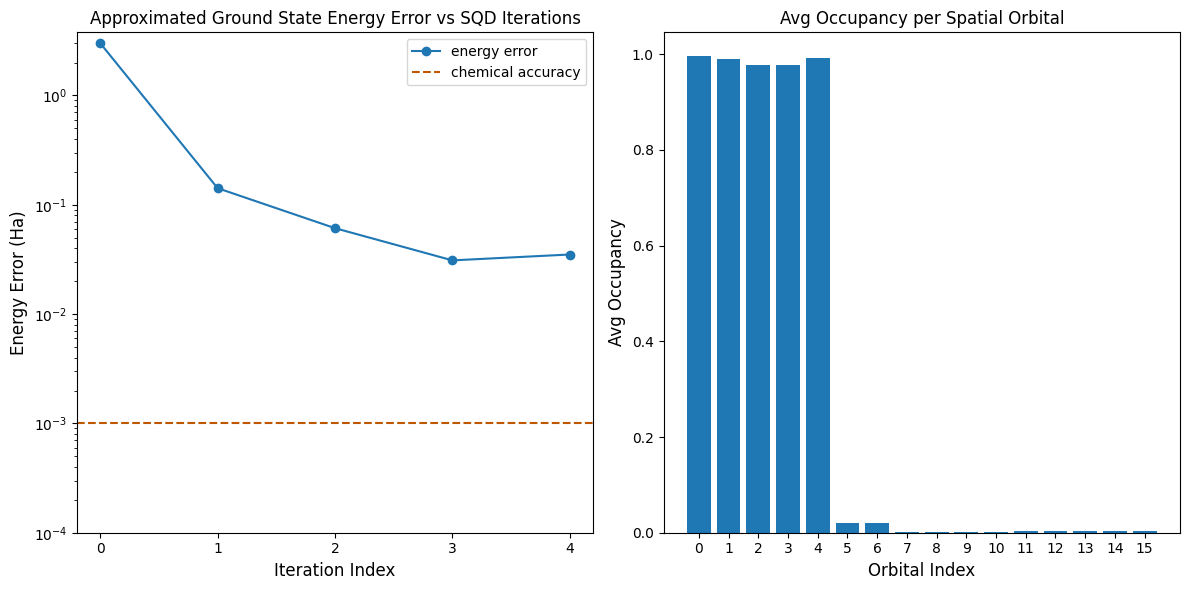

In [171]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(iterations)
e_diff = [abs(np.min(energies) - exact_energy) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.mean([occupancy_hist[-1][0], occupancy_hist[-1][1]], axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()
